In [26]:
import pandahouse 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хэши
from scipy import stats # Статистика
%matplotlib inline 

In [27]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20220720',
    'user':'student', 
    'password':'dpo_python_2020'
}

In [18]:
# Количество пользователей за выбранный период
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,42585


In [28]:
# Разбиение пользователей по группам
q = """
SELECT distinct(user_id), exp_group
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
"""
users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df. groupby('exp_group').user_id.nunique().reset_index()

,exp_group,user_id
0,0,8484
1,1,8537
2,2,8480
3,3,8569
4,4,8515


In [33]:
# Считаем ctr по каждому пользователю
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [48]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [38]:
# Увеличение масштаба графиков в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

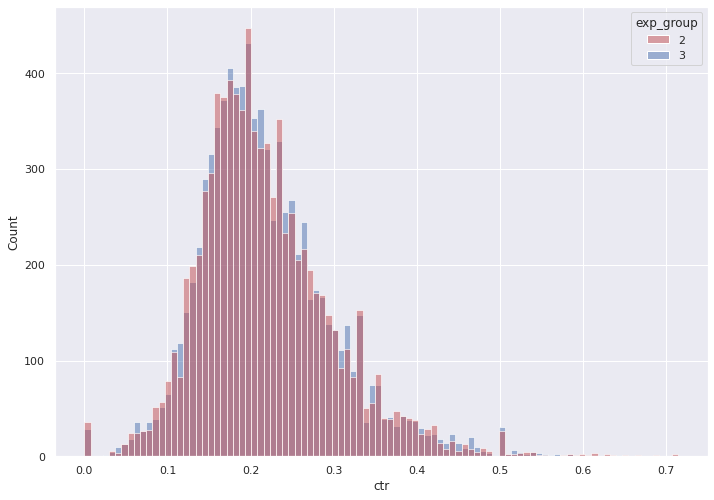

In [43]:
groups = sns.histplot(data = df,
                      x = 'ctr',
                      hue = 'exp_group',
                      palette = ['r', 'b'],
                      alpha = 0.5,
                      kde = False)

In [49]:
# Считаем ctr по каждому пользователю в группе 2
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
    and exp_group=2
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [52]:
df_ctr_2=df.ctr

In [53]:
df_ctr_2

0       0.175676
1       0.181818
2       0.141667
3       0.445378
4       0.114286
          ...   
8475    0.132075
8476    0.106667
8477    0.280702
8478    0.242424
8479    0.142857
Name: ctr, Length: 8480, dtype: float64

In [54]:
# Считаем ctr по каждому пользователю в группе 3
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2022-06-06' AND '2022-06-12'
    and exp_group=3
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [55]:
df_ctr_3 = df.ctr

In [56]:
df_ctr_3

0       0.305556
1       0.163043
2       0.143836
3       0.217391
4       0.250000
          ...   
8564    0.174528
8565    0.280000
8566    0.142857
8567    0.129032
8568    0.337838
Name: ctr, Length: 8569, dtype: float64

In [65]:
sample_ctr2 = df_ctr_2.sample(10000, replace = True).tolist()

In [60]:
sample_ctr3 = df_ctr_3.sample(10000, replace = True).tolist()

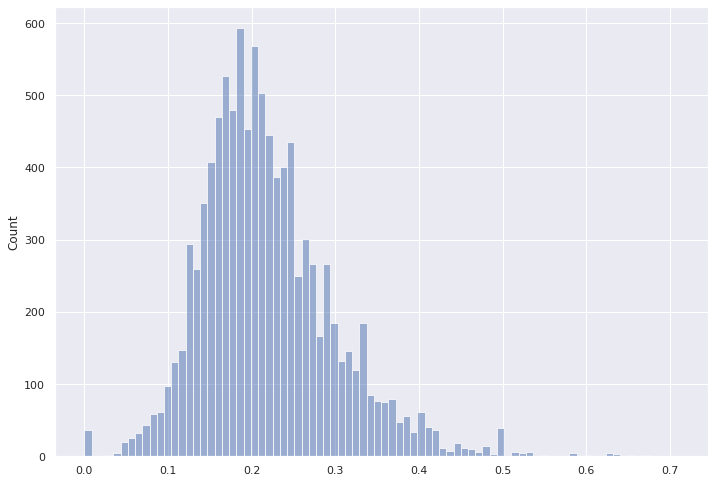

In [67]:
plot_ctr2 = sns.histplot(data = sample_ctr2,
                      palette = ['r'],
                      alpha = 0.5,
                      kde = False)

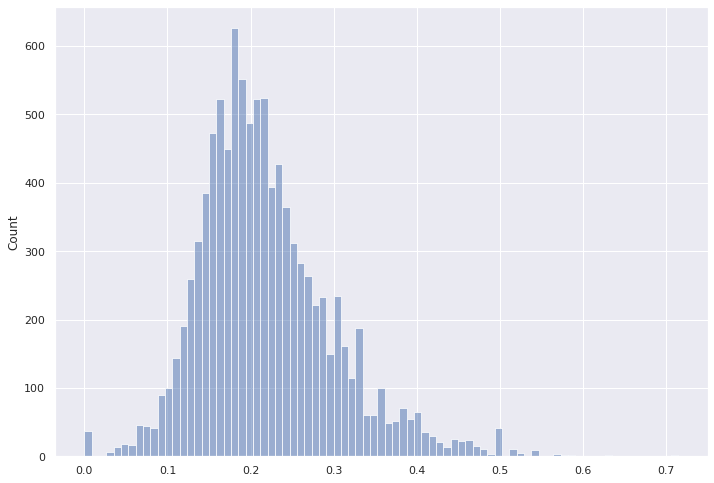

In [68]:
plot_ctr3 = sns.histplot(data = sample_ctr3,
                      palette = ['r'],
                      alpha = 0.5,
                      kde = False)

In [69]:
stats.ttest_ind(sample_ctr2,
                sample_ctr3,
                equal_var = False)

Ttest_indResult(statistic=-0.16240176081756968, pvalue=0.8709911255962662)

На основании t-теста можно сделать вывод о том, что в выборках вероятно отличий нет (pvalue=0.87). Значит, мы считаем, что АА-тест сошелся. 